In [29]:
%matplotlib inline

In [7]:
import os
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib as mpl
import seaborn as sns
from graph_tool import GraphView
from graph_tool.draw import sfdp_layout, graph_draw
from sklearn.metrics import average_precision_score
from collections import OrderedDict, defaultdict
from matplotlib import pyplot as plt

from helpers import infected_nodes, cascade_source
from graph_helpers import load_graph_by_name, remove_filters, get_edge_weights, extract_edges, extract_nodes
from random_steiner_tree.util import from_gt
from viz_helpers import lattice_node_pos
from sample_pool import TreeSamplePool
from tree_stat import TreeBasedStatistics
from experiment import gen_input
from root_sampler import build_true_root_sampler
from inference import infection_probability

from viz_helpers import visualize, query_plot_setting, default_plot_setting, tree_plot_setting, \
    set_cycler, InfectionProbabilityViz

In [56]:
graph = 'lattice-1024'
graph_suffix = '_uniform_rev'
obs_frac = "0.2"
cascade_fraction = "0.1"
obs_method = 'leaves'
cascade_model = 'si'
dataset_id = '{}-m{}-s{}-o{}-om{}'.format(graph, cascade_model, cascade_fraction, obs_frac, obs_method)
cascade_dir = 'cascade/{}'.format(dataset_id)
fig_dirname = 'figs/inf-proba-example/{}'.format(dataset_id)

cascade_id = 0

if not os.path.exists(fig_dirname):
    os.makedirs(fig_dirname)

In [50]:
SHOW_IN_NB = True

In [57]:
g = load_graph_by_name(graph, weighted=True, suffix=graph_suffix)
if graph.startswith('lattice'):
    n = int(np.sqrt(g.num_vertices()))
    pos = lattice_node_pos(g, shape=(n, n))
else:
    pos = sfdp_layout(g)

load graph from data/lattice-1024/graph_weighted_uniform_rev.gt


In [58]:
obs, c = pkl.load(open('{}/{}.pkl'.format(cascade_dir, cascade_id), 'rb'))[:2]
inf_nodes = infected_nodes(c)
source = cascade_source(c)
print('cascade size', len(infected_nodes(c)))

cascade size 103


In [59]:
inf_methods = ['our', 'pagerank', 'min-steiner-tree']

In [60]:
size = 10
plt.switch_backend('cairo')

fig, axes = plt.subplots(1, len(inf_methods) + 1, figsize=(size * (len(inf_methods) + 3), size))
for ax in axes:
    ax.axis('off')

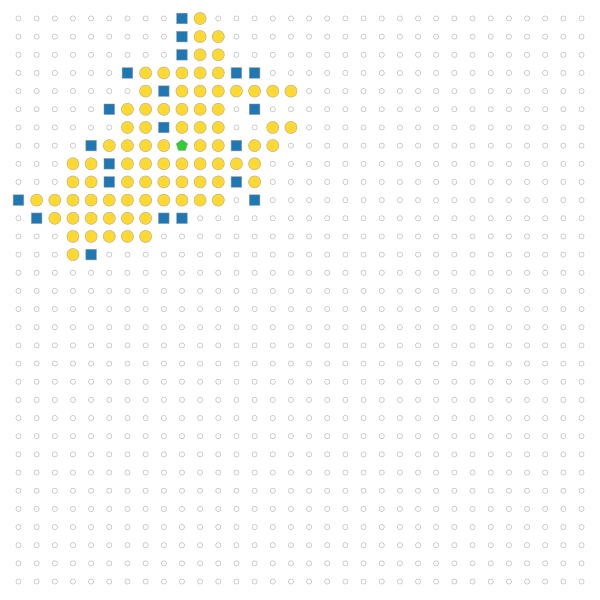

In [62]:
# plot cascade and observations
setting = default_plot_setting(g, c, obs)
visualize(g, pos,
          **setting,
          output='{}/cascade.png'.format(fig_dirname),
          ax=(axes[0] if not SHOW_IN_NB else None))

In [64]:
viz = InfectionProbabilityViz(g, pos)

In [75]:
def load_probas(method):
    path = os.path.join('output', method, dataset_id, '{}.pkl'.format(cascade_id))
    return pkl.load(open(path, 'rb'))['inf_probas']
    

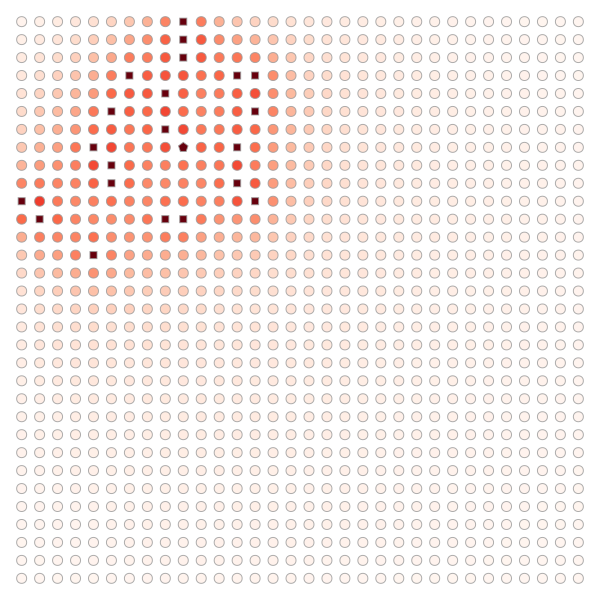

In [74]:
viz.plot(c, obs, load_probas('our-true_root'))

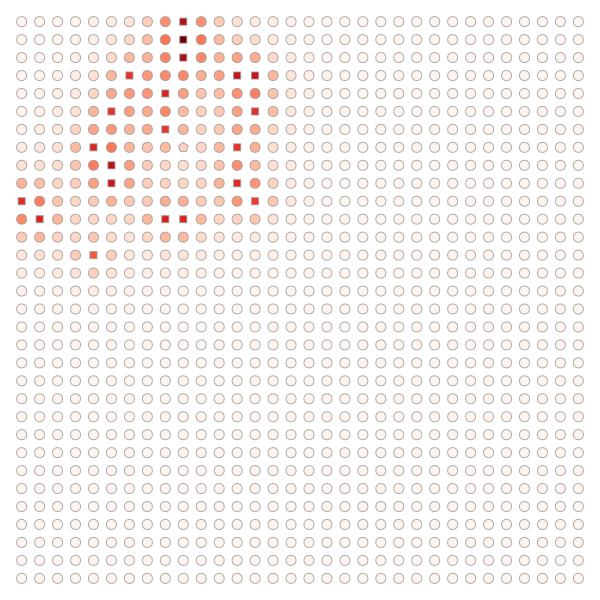

In [77]:
viz.plot(c, obs, load_probas('pagerank-true_root'))

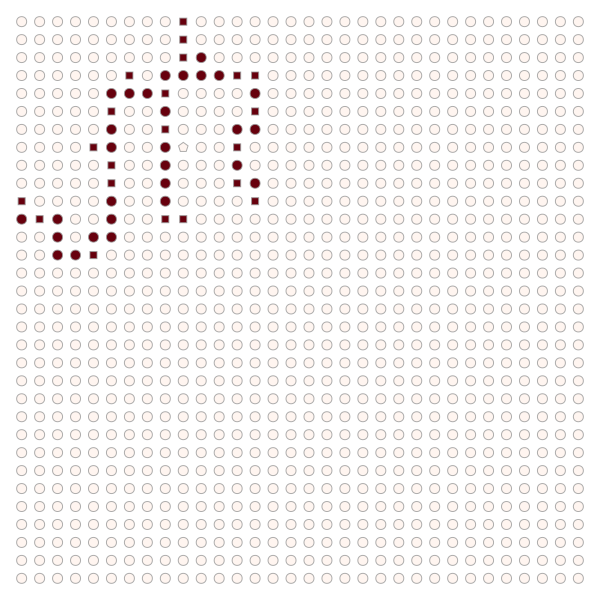

In [78]:
viz.plot(c, obs, load_probas('min-steiner-tree-true_root'))

In [52]:
# 'pagerank', 
# query_method = 'prediction_error'
n_queries_to_show = 100

def load_qs_and_probas(query_method):
    query_file_path = os.path.join(query_dir, query_method, '{}.pkl'.format(cascade_id))
    proba_file_path = os.path.join(probas_dir, query_method, '{}.pkl'.format(cascade_id))
    qs, _ = pkl.load(open(query_file_path, 'rb'))
    qs = qs[:n_queries_to_show]
    probas = pkl.load(open(proba_file_path, 'rb'))
    return qs, probas

